In [3]:
import time

import random
from scipy import stats
import simpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import simantha
from simantha.utils import create_degradation_matrix
print(simantha.__file__)
#%xmode verbose

C:\Users\Michael\Dev\maintsim\maintsim\__init__.py


Object architecture test

In [65]:
id(r)

2180998559280

In [59]:
# see: https://stackoverflow.com/questions/39887422/more-arguments-in-derived-class-init-than-base-class-init
class SimanthaCore:
    def __init__(self, name='Core'):
        self.name = name
        
class Resource(SimanthaCore):
    def __init__(self, name='Resource', capacity=1, **kwds):
        super().__init__(name, **kwds)
        
        self.capacity = capacity

In [60]:
class BaseAsset:
    def __init__(self, name=None, capacity=1):
        if name is not None:
            self.name = name
        else:
            self.name = f'Resource{id(self)}'
            
        self.capacity = 1
            
class ActiveAsset(Asset):
    """A resource object that can schedule simulation events that modify the state
    of the system. 
    """
    def __init__(self):
        pass
    
class PassiveAsset(Asset):
    def __init__(self):
        pass
        
class Machine(ActiveAsset):
    def __init__(self):
        pass
    
class Buffer(PassiveAsset):
    def __init__(self):
        pass

In [4]:
m = SimanthaCore('M1')
m.name

'M1'

In [6]:
n = Resource('M1', 1)

In [8]:
n.capacity

1

In [3]:
seed = 12345
random.seed(seed)
np.random.seed(seed)

for _ in range(1):
    sys = maintsim.System(process_times=[3,5],
                          buffer_sizes=5,
                          failure_mode='degradation',
                          failure_params={'degradation rate': [0.4, 0.4]},
                          maintenance_policy='CBM',
                          maintenance_params={'CBM threshold':[7,7]},                
                          repair_params={'CM':stats.randint(20,30),
                                         'CBM':stats.randint(10,20)},
                          maintenance_capacity=1)
    sys.simulate(warmup_time=0, sim_time=500)
    print(f'M0 idle time: {sys.machines[0].total_downtime}')
    
    total_repair = sum(sys.maintenance_data[sys.maintenance_data['activity']=='repair']['duration'])
    print(f'  Total maintenance time: {total_repair}')
    
    print('-'*40)
    print()

Simulation complete in 1.22s

  Units produced:      51
  System availability: 56.50%

M0 idle time: 278
  Total maintenance time: 435
----------------------------------------



In [9]:
ttfs = sys.maintenance_data[sys.maintenance_data['activity'] == 'failure']['duration'].values
ttfs = ttfs[ttfs != 'NA']

In [13]:
all_ttfs = np.array([999,999,999])
np.append(all_ttfs, ttfs)

array([999, 999, 999, 19, 18, 12, 11, 12, 20, 20, 11, 16, 12, 15, 19, 11,
       26, 18, 20, 16, 21, 15, 25, 15, 10, 19, 15, 12, 21, 12, 8, 12, 12,
       21, 15, 25], dtype=object)

In [16]:
system = maintsim.System(process_times=[5], 
                failure_mode='degradation',
                failure_params={'failed state': 10,
                                'degradation rate': 0.2},
                repair_params={'CM': stats.randint(2,3)})
system.simulate(sim_time=1000, verbose=False)

repairs = system.maintenance_data[system.maintenance_data['activity'] == 'repair']
total_repair_time = sum(repairs['duration'])

In [17]:
total_repair_time

34

In [18]:
system.machines[0].total_downtime

34

In [2]:
#np.random.seed(1)

P = create_degradation_matrix(10, 0.1)

system = simantha.System(
    cycle_times=[1, 3, 6, 5, 4, 2],
    degradation_matrices=[P]*6,
    buffer_capacity=10,
    cm_distribution=stats.randint(10,20)
)

n = 1
start = time.time()
for _ in range(n):
    system.simulate(0, 10000, verbose=False)
stop = time.time()
print(f'Finished in {stop-start:.2f}s, {(stop-start)/n:.4f}s/rep')

Finished in 0.34s, 0.3421s/rep


In [9]:
system.machines[0].maintenance_data

[]

In [4]:
create_degradation_matrix(5, 0.1)

array([[0.9, 0.1, 0. , 0. , 0. , 0. ],
       [0. , 0.9, 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0.9, 0.1, 0. , 0. ],
       [0. , 0. , 0. , 0.9, 0.1, 0. ],
       [0. , 0. , 0. , 0. , 0.9, 0.1],
       [0. , 0. , 0. , 0. , 0. , 1. ]])

In [32]:
P = create_degradation_matrix(10, 0.2)
env = simpy.Environment()
m = simantha.Machine(env, None, index=0, cycle_time=5, degradation_matrix=P)

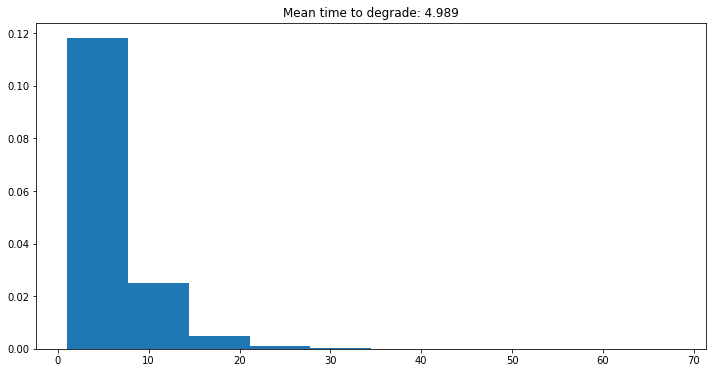

In [33]:
n = 10000
samples = []
for _ in range(n):
    samples.append(m.get_time_to_degrade())

plt.figure(figsize=(12,6))
plt.hist(samples, density=1)
plt.title(f'Mean time to degrade: {np.mean(samples)}')
plt.show()

In [4]:
sys.iterate_simulation(replications=10, objective='production')

NameError: name 'sys' is not defined

In [4]:
sys.iterate_simulation(replications=10, objective='production', parallelize=True)

TypeError: can't pickle generator objects

In [2]:
seed = 123
random.seed(seed)
np.random.seed(seed)

sys = maintsim.System(process_times=[2,5,3,4,2],
                      buffer_sizes=5,
                      failure_mode='degradation',
                      failure_params={'degradation rate': [0.2]*5},
                      maintenance_policy='CM',
                      repair_params={'CM':stats.randint(10,20)},
                      maintenance_capacity=1)
sys.simulate(warmup_time=0, sim_time=100)
print(sys.machines[sys.bottleneck].total_downtime)

Simulation complete in 0.40s

  Units produced:      10
  System availability: 91.60%

27


In [10]:
sys.production_data.to_csv('~/Downloads/production.csv')

In [11]:
sys.maintenance_data.to_csv('~/Downloads/maintnance.csv')

In [ ]:
repair_lower = 5
repair_upper = 15
system = maintsim.System(process_times=[5],
                         failure_mode='degradation',
                         failure_params={'failed state': 10,
                                         'degradation rate': 0.2},
                         repair_params={'CM': stats.randint(repair_lower,repair_upper+1)})

time_horizon = 500

# calculate true expected ttf (expected time to absorption)
def expected_ttf(Q):
    M = Q[:-1, :-1]
    I = np.identity(len(M))
    N = np.linalg.inv(I - M)
    ones = np.ones(shape=(len(M), 1))
    t = np.matmul(N, ones)
    return t

E_ttf = expected_ttf(system.machines[0].degradation)[0][0]

# expected ttr
E_ttr = (repair_lower + repair_upper) / 2

A = E_ttf / (E_ttf + E_ttr)

E_production = A * (time_horizon / system.machines[0].process_time)

reps = 200
production_samples = []
for _ in range(reps):
    system.simulate(sim_time=time_horizon, verbose=False)
    production_samples.append(system.machines[0].parts_made)

# conduct one sample t-test
# H_0: average production sample = expected production
# H_1: average production sample != expected production
_, p_value = stats.ttest_1samp(production_samples, E_production)

print('{:.6f}'.format(p_value))

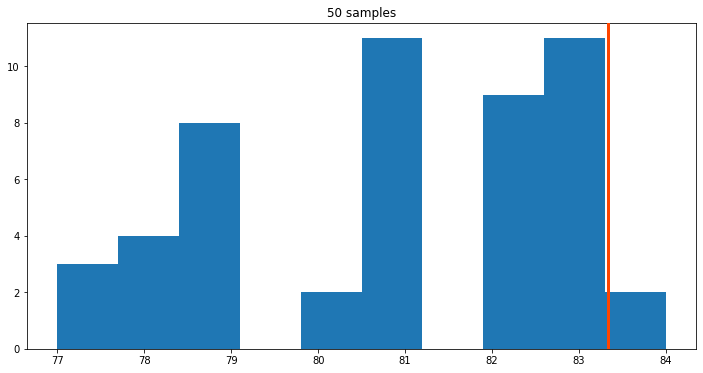

In [44]:
plt.figure(figsize=(12,6))
plt.hist(production_samples)
plt.axvline(x=E_production, color='orangered', zorder=5, lw=3)
plt.title(f'{len(production_samples)} samples')
plt.show()

In [41]:
print('Expected: ', E_production)
print('Observerd:', np.mean(production_samples))

Expected:  83.3333333333
Observerd: 80.9


In [16]:
# find expexted time to failure from each state
def expected_ttf(Q):
    M = Q[:-1, :-1]
    I = np.identity(len(M))
    N = np.linalg.inv(I - M)
    ones = np.ones(shape=(len(M), 1))
    t = np.matmul(N, ones)
    return t

In [21]:
expected_ttf(mm.P)[0][0]

50.000000000000071

In [15]:
mm.mfpt(1, 3)#sys.machines[2].failed_state)

C:\Users\mlh6\AppData\Local\Continuum\anaconda3\envs\maintenance\lib\site-packages\msmtools\analysis\dense\mean_first_passage_time.py:126: RuntimeWarning: invalid value encountered in true_divide
  muX = nuX / np.sum(nuX)


LinAlgError: Matrix is singular.

In [10]:
ttfs = sys.maintenance_data[sys.maintenance_data['activity'] == 'failure']['duration'].values
ttfs = ttfs[ttfs != 'NA']
ttfs

array([37, 64, 47, 53, 44, 41, 46, 36, 52, 60, 52, 52, 38, 68, 57, 41, 52,
       39, 33, 57, 34, 49, 42, 38, 42], dtype=object)

In [3]:
queue = sys.queue_data[sys.queue_data['time'] >= 0]
queue[:10]

,time,level,contents
100,0.0,0.0,[]
101,1.0,0.0,[]
102,2.0,0.0,[]
103,3.0,0.0,[]
104,4.0,0.0,[]
105,5.0,0.0,[]
106,6.0,0.0,[]
107,7.0,0.0,[]
108,8.0,0.0,[]
109,9.0,0.0,[]


In [4]:
maintenance = sys.maintenance_data[sys.maintenance_data['time'] >= 0]
maintenance[:10]

,time,machine,type,activity,duration
20,9,3,CM,failure,30
21,15,2,CM,failure,26
22,18,1,CM,failure,37
23,22,4,CM,failure,30
24,24,0,CM,failure,34
25,27,3,CM,repair,17
26,31,1,CM,repair,12
27,32,2,CM,repair,16
28,34,4,CM,repair,11
29,39,3,CM,failure,12


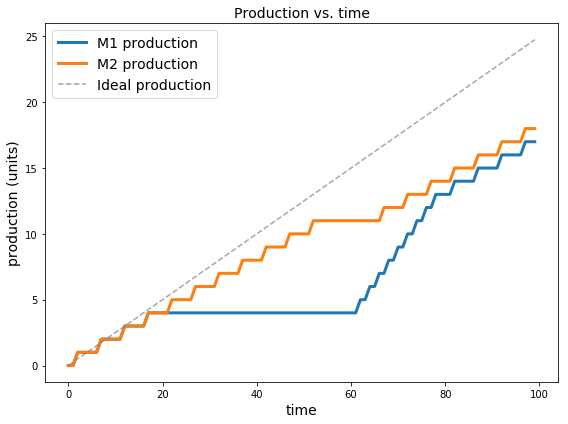

In [9]:
plt.figure(figsize=(8,6))
prod = sys.production_data[sys.production_data['time'] >= 0]
plt.plot(prod['time'], prod['M0 production'], label='M1 production', lw=3)
plt.plot(prod['time'], prod['M1 production'], label='M2 production', lw=3)
plt.plot(prod['time'], prod['time']/4, '--', color='gray', alpha=0.7,
         label='Ideal production')
plt.title('Production vs. time', fontsize=14)
plt.xlabel('time', fontsize=14)
plt.ylabel('production (units)', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('/Users/mlh6/Work/Proposal/Figures/ppl.eps', format='eps')
plt.show()

In [24]:
sys = maintsim.System(process_times=[2,5,3],
                      buffer_sizes=5,
                      failure_mode='degradation',
                      failure_params=[0.2, 0.1, 0.25],
                      repair_params={'CM':stats.randint(10,20)},
                      maintenance_capacity=1)
                      #planned_failures=[(0,20,40), (2,70,20)])
sys.simulate(warmup_time=100, sim_time=501)

M0 failed at t=29
M0 yielded CM request at t=29
M2 failed at t=36
M0 repaired at t=42
M2 yielded CM request at t=42
M2 repaired at t=53
M0 failed at t=79
M0 yielded CM request at t=79
M2 failed at t=91
M0 repaired at t=92
M2 yielded CM request at t=92
M1 failed at t=100
M2 repaired at t=103
M1 yielded CM request at t=103
M1 repaired at t=122
M2 failed at t=125
M2 yielded CM request at t=125
M2 repaired at t=137
M0 failed at t=156
M0 yielded CM request at t=156
M0 repaired at t=168
M1 failed at t=179
M1 yielded CM request at t=179
M1 repaired at t=195
M2 failed at t=196
M2 yielded CM request at t=196
M2 repaired at t=212
M0 failed at t=224
M0 yielded CM request at t=224
M0 repaired at t=242
M2 failed at t=250
M2 yielded CM request at t=250
M1 failed at t=252
M2 repaired at t=261
M1 yielded CM request at t=261
M1 repaired at t=277
M0 failed at t=283
M0 yielded CM request at t=283
M0 repaired at t=296
M2 failed at t=308
M2 yielded CM request at t=308
M2 repaired at t=318
M0 failed at t=35

In [11]:
sys.production_data.head()

,time,M0 production,M0 throughput,M1 production,M1 throughput,M2 production,M2 throughput
0,-100.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
1,-99.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
2,-98.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
3,-97.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
4,-96.0,0.0,-0.0,0.0,-0.0,0.0,-0.0


In [27]:
sys.maintenance_data

,time,machine,type,activity,duration
0,-71,0,CM,failure,NA
1,-58,0,CM,repair,13
2,-64,2,CM,failure,NA
3,-47,2,CM,repair,11
4,-21,0,CM,failure,37
5,-8,0,CM,repair,13
6,-9,2,CM,failure,39
7,3,2,CM,repair,11
8,0,1,CM,failure,NA
9,22,1,CM,repair,19


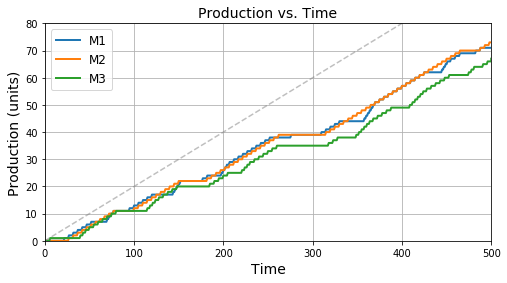

In [51]:
prod_data = sys.production_data[sys.production_data['time'] >= 0]
plt.figure(figsize=(8,4))
for i in range(sys.M):
    plt.plot(prod_data['time'] ,prod_data['M{} production'.format(i)], 
             lw=2, label='M{}'.format(i+1))
plt.plot([0,500],[0,500/5], '--', c='gray', alpha=0.5)
plt.xlim([0,500])
plt.ylim([0,80])
plt.xlabel('Time', fontsize=14)
plt.ylabel('Production (units)', fontsize=14)
plt.title('Production vs. Time', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.savefig('/Users/mlh6/Downloads/maintsim1.png', format='png')
plt.show()

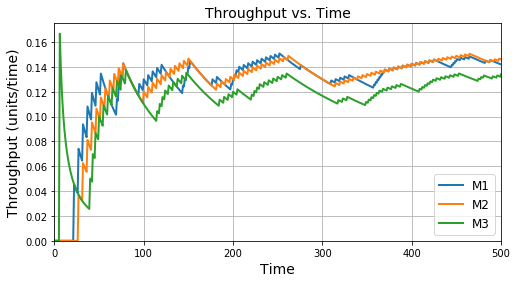

In [50]:
#prod_data = sys.production_data[sys.production_data['time'] >= 0]
plt.figure(figsize=(8,4))
for i in range(sys.M):
    plt.plot(prod_data['time'] ,prod_data['M{} throughput'.format(i)], 
             lw=2, label='M{}'.format(i+1))
#plt.plot([0,500],[0,500/5], '--', c='gray', alpha=0.5)
#plt.axhline
plt.xlim([0,500])
plt.ylim([0,0.175])
plt.xlabel('Time', fontsize=14)
plt.ylabel('Throughput (units/time)', fontsize=14)
plt.title('Throughput vs. Time', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.savefig('/Users/mlh6/Downloads/maintsim2.png', format='png')
plt.show()

In [65]:
sys = maintsim.System(process_times=[3, 5, 4],
                      buffer_sizes=10,
                      failure_mode='degradation',
                      failure_params=[0.45]*3,
                      maintenance_policy='CBM',
                      maintenance_params={'CBM threshold':[10,10,10]},
                      repair_params={'CM':stats.randint(10,50),
                                     'CBM':stats.randint(15,55)},
                      # repair_params={'CM':{'uniform':{'low':10,'high':20)},
                      #                'PM':{'uniform':{'low':5, 'high':10}}},
                      maintenance_capacity=1, debug=True)

In [66]:
sys.simulate(sim_time=100)

0 [] [] []
1 [] [] []
2 [] [] []
3 [] [] []
4 [] [] []
5 [] [] []
6 [] [] []
7 [] [] []
8 [] [] []
9 [] [] []
10 [] [] []
11 [] [<PriorityRequest() object at 0x1a14a09860>] []
12 [] [<PriorityRequest() object at 0x1a14a09860>] [<PriorityRequest() object at 0x1a14a09c18>, <PriorityRequest() object at 0x1a14c7bd30>]
13 [] [<PriorityRequest() object at 0x1a14a09860>] [<PriorityRequest() object at 0x1a14a09c18>, <PriorityRequest() object at 0x1a14c7bd30>]
14 [] [<PriorityRequest() object at 0x1a14a09860>] [<PriorityRequest() object at 0x1a14a09c18>, <PriorityRequest() object at 0x1a14c7bd30>]
15 [] [<PriorityRequest() object at 0x1a14a09860>] [<PriorityRequest() object at 0x1a14a09c18>, <PriorityRequest() object at 0x1a14c7bd30>]
16 [] [<PriorityRequest() object at 0x1a14a09860>] [<PriorityRequest() object at 0x1a14a09c18>, <PriorityRequest() object at 0x1a14c7bd30>]
17 [] [<PriorityRequest() object at 0x1a14a09860>] [<PriorityRequest() object at 0x1a14a09c18>, <PriorityRequest() object at

In [67]:
while (not sys.repairman.put_queue) and (not sys.repairman.get_queue):
    sys.simulate(sim_time=100, verbose=False)
print(sys.repairman.put_queue)
print(sys.repairman.get_queue)

[<PriorityRequest() object at 0x1a14cc36d8>, <PriorityRequest() object at 0x1a14cc5cc0>]
[]


In [70]:
dir(sys.repairman.put_queue[0])

['__and__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_desc',
 '_value',
 'callbacks',
 'cancel',
 'defused',
 'env',
 'fail',
 'key',
 'ok',
 'preempt',
 'priority',
 'proc',
 'processed',
 'resource',
 'succeed',
 'time',
 'trigger',
 'triggered',
 'usage_since',
 'value']

In [83]:
sys.repairman.put_queue[0]

<PriorityRequest() object at 0x1a14cc36d8>

In [62]:
sys.repairman.put_queue

[]

In [14]:
sys.machine_data[['M{} health'.format(m) for m in range(3)]].ffill()[40:60]

,M0 health,M1 health,M2 health
40,9.0,10.0,10.0
41,9.0,10.0,10.0
42,9.0,10.0,10.0
43,9.0,10.0,10.0
44,10.0,10.0,10.0
45,10.0,10.0,10.0
46,10.0,10.0,10.0
47,10.0,10.0,10.0
48,10.0,10.0,0.0
49,10.0,0.0,0.0


In [10]:
sys.env.now

22

In [18]:
sys = maintsim.System(process_times=[3, 4],
                      buffer_sizes=10,
                      failure_mode='degradation',
                      failure_params=[0.25]*2,
                      maintenance_policy='CBM',
                      maintenance_params={'CBM threshold':[7,6]},
                      repair_params={'CM':stats.randint(10,20),
                                     'CBM':stats.randint(20,25)},
                      # repair_params={'CM':{'uniform':{'low':10,'high':20)},
                      #                'PM':{'uniform':{'low':5, 'high':10}}},
                      maintenance_capacity=1,
                      debug=0)

In [25]:
sys.simulate(sim_time=100)

M1 CBM requested at t=24
M1 requesting maintenance at t=24
M1 stopped production at t=24
M1 starting matinenance at t=24
degradation interrupted at t=24
M0 CBM requested at t=36
M0 requesting maintenance at t=36
M1 resumed production at t=47
M0 stopped production at t=47
M0 starting matinenance at t=47
degradation interrupted at t=47
M0 resumed production at t=68
M1 CBM requested at t=75
M1 requesting maintenance at t=76
M1 stopped production at t=76
M1 starting matinenance at t=76
degradation interrupted at t=76
M1 resumed production at t=100
Simulation complete in 0.18s

  Units produced:      12
  System availability: 66.00%



In [6]:
sys.env.step()
print(sys.repairman.users, sys.repairman.put_queue)

[<PriorityRequest() object at 0x1a235f27f0>] [<PriorityRequest() object at 0x1a23606198>, <PriorityRequest() object at 0x1a23606c50>, <PriorityRequest() object at 0x1a2360e7b8>]


In [24]:
sys.maintenance_data

,time,machine,type,activity,duration
0,25,0,CBM,failure,NA
1,49,0,CBM,repair,24
2,44,1,CM,failure,NA
3,67,1,CM,repair,18
4,68,0,CBM,failure,19
5,91,0,CBM,repair,23


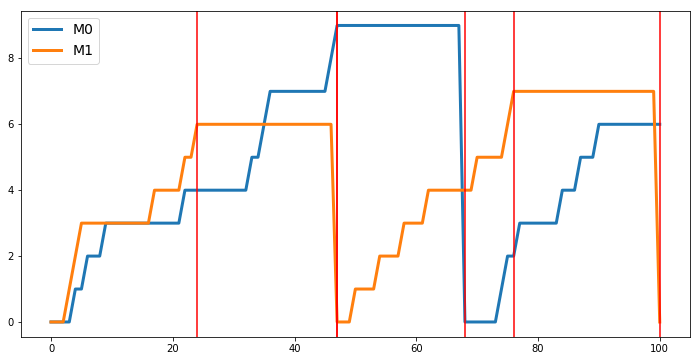

In [26]:
plt.figure(figsize=(12,6))
plt.plot(sys.machine_data['M0 health'], label='M0', lw=3)
plt.plot(sys.machine_data['M1 health'], label='M1', lw=3)
for t in sys.maintenance_data['time']: plt.axvline(x=t, color='red')
plt.legend(fontsize=14)
plt.show()

In [55]:
sys.machines[1].failed

True

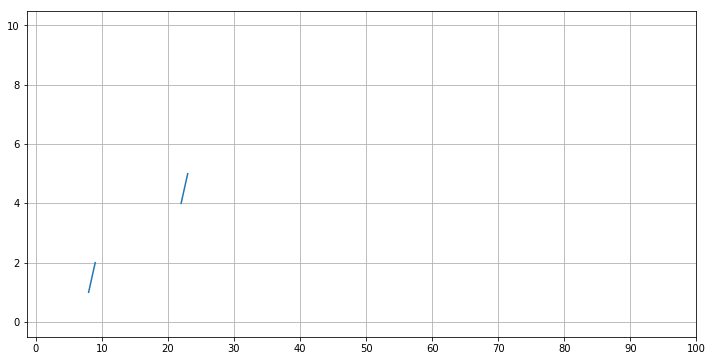

In [11]:
plt.figure(figsize=(12,6))
plt.plot(sys.machine_data[['M0 health', 'M1 health']])
plt.xticks(np.arange(0,101,10))
colors = ['red', 'orange']
for t in sys.maintenance_data['time'].values:
    #plt.axvline(x=t, c='red')
    pass
plt.grid()
plt.show()

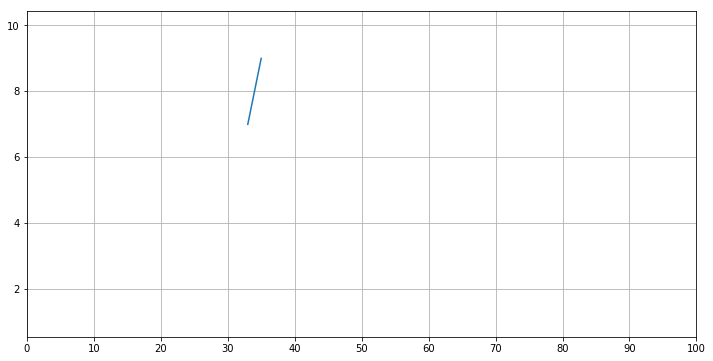

In [5]:
plt.figure(figsize=(12,6))
plt.plot(sys.machine_data[['M{} health'.format(m) for m in range(1)]])
plt.xticks(np.arange(0,101,10))
plt.grid()
plt.show()

In [38]:
sys.machine_data[['M{} health'.format(m) for m in range(3)]]

,M0 health,M1 health,M2 health
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,1.0,0.0
3,1.0,2.0,0.0
4,1.0,2.0,0.0
5,2.0,2.0,0.0
6,2.0,2.0,0.0
7,2.0,2.0,0.0
8,2.0,2.0,0.0
9,2.0,2.0,0.0
